# Task 3 — Customer Segmentation
**Saiket Systems — Data Science Internship**

**Goal:** Segment customers based on `tenure`, `MonthlyCharges`, and `Contract` type.  
Analyze churn rates inside segments and identify high-value customers who are at risk of churning.

**Plan**
1. Load cleaned dataset.
2. Create rule-based segments (tenure × monthly charges × contract).
3. Analyze churn rate, size and revenue per segment.
4. Visualize segment behavior.
5. Perform clustering (KMeans) as alternate segmentation and visualize.
6. Identify high-value but high-risk customers and export for business action.


In [1]:
# =========================
# 1 — IMPORTS & SETTINGS
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)


In [2]:
# =========================
# 2 — Load cleaned dataset
# =========================
df = pd.read_csv("dataset/Telco_Customer_Churn_Dataset_cleaned.csv")
print("shape:", df.shape)
df.head()


shape: (7043, 32)


,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,7590-VHVEG,0,1,29.85,29.85,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False
1,5575-GNVDE,0,34,56.95,1889.50,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False
2,3668-QPYBK,0,2,53.85,108.15,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True
3,7795-CFOCW,0,45,42.30,1840.75,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False
4,9237-HQITU,0,2,70.70,151.65,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True


## Notes about the cleaned dataset
We expect the same columns as Task-2 (customerID, tenure, MonthlyCharges, TotalCharges, Contract_One year, Contract_Two year, PaymentMethod_..., Churn_Yes, etc.)


In [4]:
# Quick check of important columns
cols_to_check = ['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges',
                 'Contract_One year','Contract_Two year',
                 'PaymentMethod_Electronic check',
                 'InternetService_Fiber optic', 'Churn_Yes']
for c in cols_to_check:
    print(c, c in df.columns)


customerID True
tenure True
MonthlyCharges True
TotalCharges True
Contract_One year True
Contract_Two year True
PaymentMethod_Electronic check True
InternetService_Fiber optic True
Churn_Yes True


# 2 — Rule-based segmentation (simple & explainable)
We'll build segments using:
- `tenure` buckets: New (<=12), Established (13-36), Loyal (>36)
- `MonthlyCharges` buckets: Low / Medium / High (tertiles)
- `Contract`: Month-to-month / One-year / Two-year (we infer month-to-month where both flags False)


In [5]:
# TENURE buckets
def tenure_bucket(t):
    if t <= 12:
        return "New (<=12)"
    elif t <= 36:
        return "Established (13-36)"
    else:
        return "Loyal (>36)"

df['tenure_bucket'] = df['tenure'].apply(tenure_bucket)

# MONTHLY CHARGES terciles
mc_q = df['MonthlyCharges'].quantile([0.33, 0.66]).values
def charges_bucket(m):
    if m <= mc_q[0]:
        return "Low"
    elif m <= mc_q[1]:
        return "Medium"
    else:
        return "High"

df['charge_bucket'] = df['MonthlyCharges'].apply(charges_bucket)

# CONTRACT type: infer month-to-month if neither one-yr nor two-yr flags set
def contract_type(row):
    if row.get('Contract_One year', False):
        return 'One year'
    if row.get('Contract_Two year', False):
        return 'Two year'
    return 'Month-to-month'

df['contract_type'] = df.apply(contract_type, axis=1)

# Composite segment label
df['segment_rule'] = df['tenure_bucket'] + " | " + df['charge_bucket'] + " | " + df['contract_type']

# Quick peek
df[['customerID','tenure','tenure_bucket','MonthlyCharges','charge_bucket','contract_type','segment_rule','Churn_Yes']].head()


,customerID,tenure,tenure_bucket,MonthlyCharges,charge_bucket,contract_type,segment_rule,Churn_Yes
0,7590-VHVEG,1,New (<=12),29.85,Low,Month-to-month,New (<=12) | Low | Month-to-month,False
1,5575-GNVDE,34,Established (13-36),56.95,Medium,One year,Established (13-36) | Medium | One year,False
2,3668-QPYBK,2,New (<=12),53.85,Medium,Month-to-month,New (<=12) | Medium | Month-to-month,True
3,7795-CFOCW,45,Loyal (>36),42.30,Low,One year,Loyal (>36) | Low | One year,False
4,9237-HQITU,2,New (<=12),70.70,Medium,Month-to-month,New (<=12) | Medium | Month-to-month,True


# 3 — Segment-level aggregation & churn analysis
We will compute for each segment:
- count (#customers)
- churn rate
- average MonthlyCharges and TotalCharges
- proportion of company revenue (avg MonthlyCharges * count)


In [6]:
seg_agg = df.groupby('segment_rule').agg(
    customers = ('customerID', 'count'),
    churn_count = ('Churn_Yes', 'sum'),
    churn_rate = ('Churn_Yes', 'mean'),
    avg_monthly = ('MonthlyCharges', 'mean'),
    avg_total = ('TotalCharges', 'mean')
).reset_index()

seg_agg['estimated_monthly_revenue'] = seg_agg['avg_monthly'] * seg_agg['customers']
seg_agg = seg_agg.sort_values('customers', ascending=False).reset_index(drop=True)
seg_agg.head(20)


,segment_rule,customers,churn_count,churn_rate,avg_monthly,avg_total,estimated_monthly_revenue
0,New (<=12) | Medium | Month-to-month,822,456,0.554745,69.249209,310.662652,56922.85000
1,New (<=12) | Low | Month-to-month,790,283,0.358228,30.376899,116.479747,23997.75000
2,Loyal (>36) | High | Two year,558,31,0.055556,100.530062,6670.232175,56095.77464
3,Loyal (>36) | Low | Two year,517,5,0.009671,24.225532,1456.149807,12524.60000
4,Established (13-36) | High | Month-to-month,514,256,0.498054,93.873249,2250.827335,48250.85000
5,Established (13-36) | Medium | Month-to-month,443,137,0.309255,69.004966,1525.953725,30569.20000
6,Loyal (>36) | High | One year,440,84,0.190909,100.400308,5790.964363,44176.13548
7,Loyal (>36) | High | Month-to-month,402,142,0.353234,97.370897,5024.934621,39143.10046
8,New (<=12) | High | Month-to-month,382,285,0.746073,92.070026,535.003534,35170.75000
9,Loyal (>36) | Medium | Two year,366,10,0.027322,69.385656,4369.415847,25395.15000


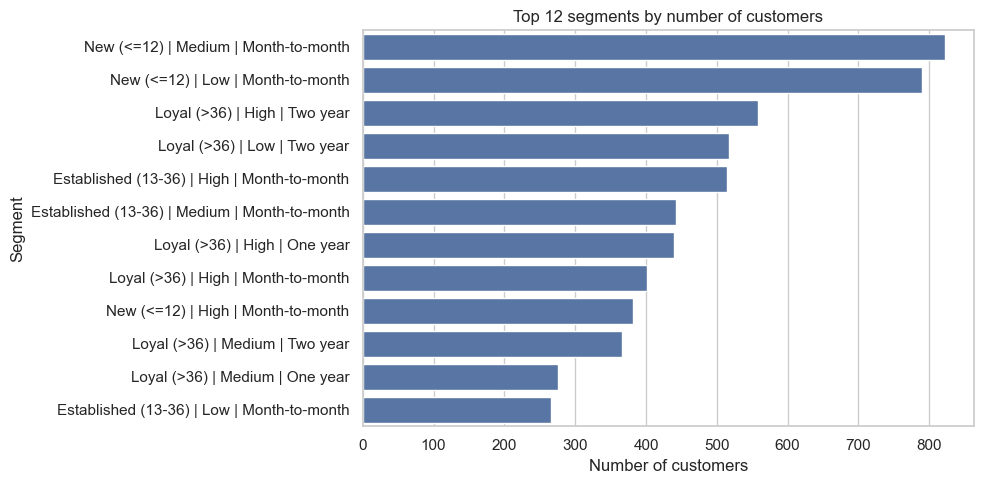

In [7]:
# Show top segments by size
plt.figure(figsize=(10,5))
sns.barplot(data=seg_agg.sort_values('customers', ascending=False).head(12),
            x='customers', y='segment_rule')
plt.title("Top 12 segments by number of customers")
plt.xlabel("Number of customers")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()


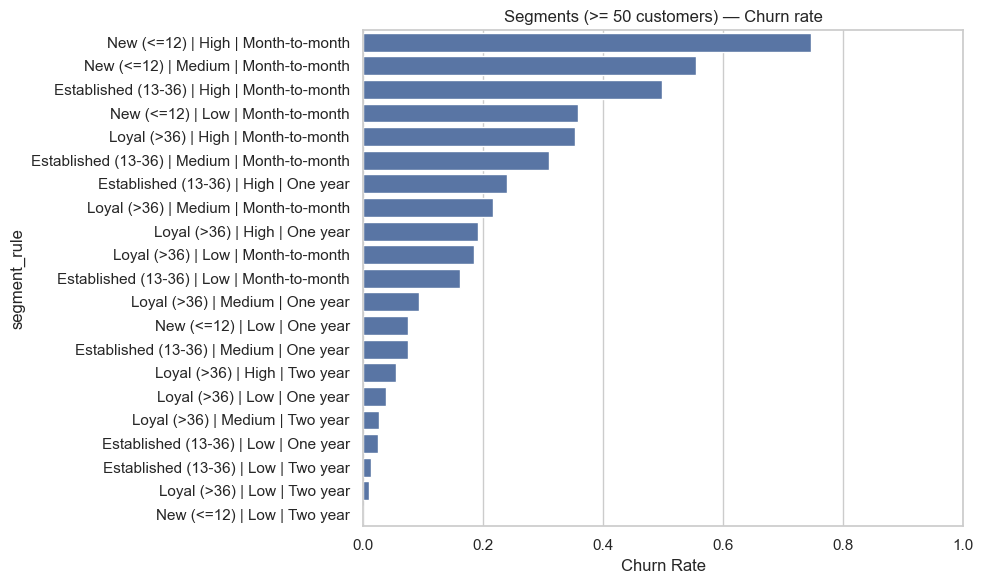

In [8]:
# Show segments by churn rate (only segments with at least N customers to avoid noisy tiny groups)
min_customers = 50
seg_for_plot = seg_agg[seg_agg['customers'] >= min_customers].sort_values('churn_rate', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=seg_for_plot, x='churn_rate', y='segment_rule')
plt.xlabel("Churn Rate")
plt.title(f"Segments (>= {min_customers} customers) — Churn rate")
plt.xlim(0,1)
plt.tight_layout()
plt.show()


### Observations to report
- Which segments have high churn and high revenue (dangerous).
- Which segments are large and have high churn (priority).
- Which segments are loyal and high-value (keepers).


In [9]:
# Mark segments that are High-Risk High-Value:
# Criteria (example): top 30% churn_rate among sizable segments and avg_monthly in top 30%
sizable = seg_agg[seg_agg['customers'] >= min_customers].copy()
churn_thr = sizable['churn_rate'].quantile(0.7)
revenue_thr = sizable['avg_monthly'].quantile(0.7)

sizable['risk_category'] = 'normal'
sizable.loc[(sizable['churn_rate'] >= churn_thr) & (sizable['avg_monthly'] >= revenue_thr), 'risk_category'] = 'high-risk-high-value'
sizable.loc[(sizable['churn_rate'] >= churn_thr) & (sizable['avg_monthly'] < revenue_thr), 'risk_category'] = 'high-risk-low-value'
sizable.loc[(sizable['churn_rate'] < churn_thr) & (sizable['avg_monthly'] >= revenue_thr), 'risk_category'] = 'low-risk-high-value'

sizable[['segment_rule','customers','churn_rate','avg_monthly','risk_category']].sort_values(['risk_category','churn_rate'], ascending=[True,False]).head(20)


,segment_rule,customers,churn_rate,avg_monthly,risk_category
8,New (<=12) | High | Month-to-month,382,0.746073,92.070026,high-risk-high-value
4,Established (13-36) | High | Month-to-month,514,0.498054,93.873249,high-risk-high-value
7,Loyal (>36) | High | Month-to-month,402,0.353234,97.370897,high-risk-high-value
19,Established (13-36) | High | One year,75,0.240000,95.808224,high-risk-high-value
0,New (<=12) | Medium | Month-to-month,822,0.554745,69.249209,high-risk-low-value
1,New (<=12) | Low | Month-to-month,790,0.358228,30.376899,high-risk-low-value
5,Established (13-36) | Medium | Month-to-month,443,0.309255,69.004966,high-risk-low-value
6,Loyal (>36) | High | One year,440,0.190909,100.400308,low-risk-high-value
2,Loyal (>36) | High | Two year,558,0.055556,100.530062,low-risk-high-value
9,Loyal (>36) | Medium | Two year,366,0.027322,69.385656,low-risk-high-value


# 4 — Visual breakdowns: Tenure x MonthlyCharges x Contract
We will create useful visuals:
- churn rate heatmap for tenure_bucket vs charge_bucket
- stacked bar for contract types vs churn


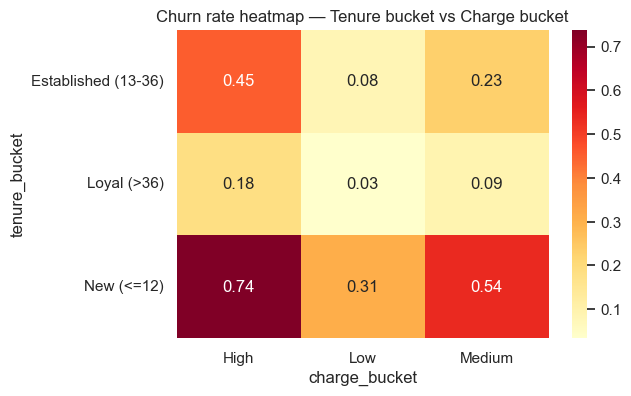

In [10]:
# pivot table: churn rate
pivot = df.pivot_table(index='tenure_bucket', columns='charge_bucket', values='Churn_Yes', aggfunc='mean')
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='YlOrRd')
plt.title("Churn rate heatmap — Tenure bucket vs Charge bucket")
plt.show()


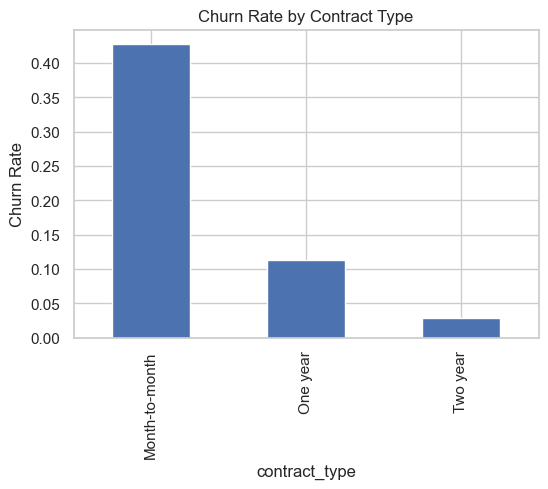

In [11]:
# contract type vs churn
plt.figure(figsize=(6,4))
ct = df.groupby(['contract_type'])['Churn_Yes'].mean().sort_values(ascending=False)
ct.plot(kind='bar')
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Contract Type")
plt.show()


# 5 — Clustering (KMeans) — alternative segmentation
We'll use numeric behaviours and a couple of important flags to cluster customers.
Features used (example):
- `tenure`, `MonthlyCharges`, `TotalCharges`, `InternetService_Fiber optic`, `PaymentMethod_Electronic check`
Scale the numeric features, run KMeans for k in [2..6], pick best by silhouette.


In [12]:
# Prepare features
feat_cols = ['tenure','MonthlyCharges','TotalCharges','InternetService_Fiber optic','PaymentMethod_Electronic check']
X = df[feat_cols].copy()

# Convert boolean columns to int (if any)
for c in X.select_dtypes('bool').columns:
    X[c] = X[c].astype(int)

# Scale numeric
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find best k by silhouette
scores = {}
for k in range(2,7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores[k] = score

scores


{2: 0.37261520110831503,
 3: 0.40311025658300076,
 4: 0.3967069643731857,
 5: 0.4277488973405104,
 6: 0.4691912511571166}

In [13]:
# Choose k with highest silhouette
best_k = max(scores, key=scores.get)
best_k, scores


(6,
 {2: 0.37261520110831503,
  3: 0.40311025658300076,
  4: 0.3967069643731857,
  5: 0.4277488973405104,
  6: 0.4691912511571166})

In [14]:
# Fit final KMeans and store cluster labels
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Quick cluster counts and churn rates
cluster_summary = df.groupby('kmeans_cluster').agg(
    customers=('customerID','count'),
    churn_rate=('Churn_Yes','mean'),
    avg_monthly=('MonthlyCharges','mean'),
    avg_tenure=('tenure','mean')
).reset_index().sort_values('customers', ascending=False)
cluster_summary


,kmeans_cluster,customers,churn_rate,avg_monthly,avg_tenure
5,5,1849,0.160627,34.236236,15.989183
0,0,1387,0.041817,54.991997,59.151406
1,1,1191,0.618808,85.913728,14.791772
2,2,1183,0.187658,100.732215,60.451395
4,4,735,0.459864,85.487189,18.620408
3,3,698,0.310888,46.034312,19.451289


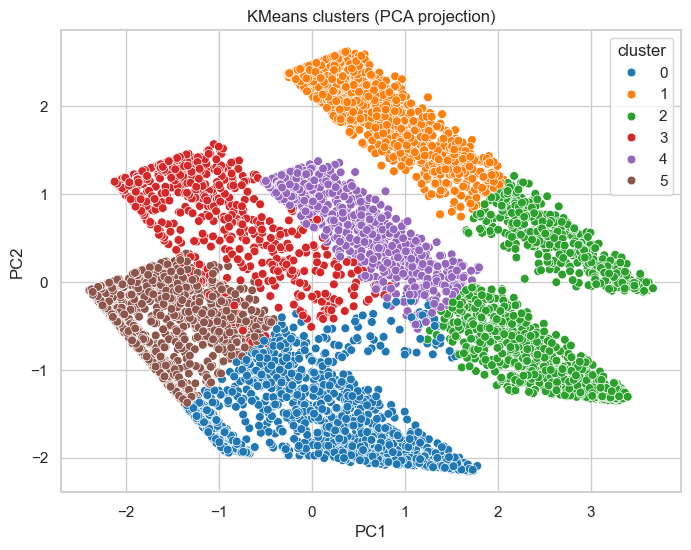

In [15]:
# Visualize clusters with PCA (2D)
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=df['kmeans_cluster'], palette='tab10', s=40)
plt.title("KMeans clusters (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='cluster')
plt.show()


# 6 — Identify high-value but at-risk customers (business action)
Define high-value as customers in top-quartile of `MonthlyCharges` or `TotalCharges`, and at-risk as those in high risk segments from rule-based segmentation (or cluster with high churn rate).
We'll produce a list of customers to target with retention offers.


In [16]:
# Top-quartile thresholds
mc_q3 = df['MonthlyCharges'].quantile(0.75)
tc_q3 = df['TotalCharges'].quantile(0.75)

# Which rule-based segments we flagged as high-risk-high-value?
hrhv_segments = sizable[sizable['risk_category']=='high-risk-high-value']['segment_rule'].tolist()

# Customers who meet high-value & in those risky segments OR in clusters with high churn:
clusters_high_churn = cluster_summary[cluster_summary['churn_rate'] >= cluster_summary['churn_rate'].quantile(0.66)]['kmeans_cluster'].tolist()

high_value_risky = df[
    (
      ((df['MonthlyCharges'] >= mc_q3) | (df['TotalCharges'] >= tc_q3))
      & df['segment_rule'].isin(hrhv_segments)
    )
    | (df['kmeans_cluster'].isin(clusters_high_churn) & ((df['MonthlyCharges'] >= mc_q3) | (df['TotalCharges'] >= tc_q3)))
].copy()

print("High-value & at-risk customers count:", high_value_risky.shape[0])
high_value_risky[['customerID','tenure','MonthlyCharges','TotalCharges','contract_type','segment_rule','Churn_Yes','kmeans_cluster']].head(20)


High-value & at-risk customers count: 1031


,customerID,tenure,MonthlyCharges,TotalCharges,contract_type,segment_rule,Churn_Yes,kmeans_cluster
5,9305-CDSKC,8,99.65,820.50,Month-to-month,New (<=12) | High | Month-to-month,True,1
8,7892-POOKP,28,104.80,3046.05,Month-to-month,Established (13-36) | High | Month-to-month,True,1
13,0280-XJGEX,49,103.70,5036.30,Month-to-month,Loyal (>36) | High | Month-to-month,True,2
14,5129-JLPIS,25,105.50,2686.05,Month-to-month,Established (13-36) | High | Month-to-month,False,1
19,4183-MYFRB,21,90.05,1862.90,Month-to-month,Established (13-36) | High | Month-to-month,False,1
26,6467-CHFZW,47,99.35,4749.15,Month-to-month,Loyal (>36) | High | Month-to-month,True,2
31,4929-XIHVW,2,95.50,181.65,Month-to-month,New (<=12) | High | Month-to-month,False,4
38,5380-WJKOV,34,106.35,3549.25,Month-to-month,Established (13-36) | High | Month-to-month,True,1
39,8168-UQWWF,11,97.85,1105.40,Month-to-month,New (<=12) | High | Month-to-month,True,4
45,3714-NTNFO,49,84.50,3906.70,Month-to-month,Loyal (>36) | High | Month-to-month,False,1


In [23]:
# Export the high-value at-risk customers for business team
high_value_risky.to_csv("reports/high_value_at_risk_customers.csv", index=False)
print("Saved: reports/high_value_at_risk_customers.csv")


Saved: reports/high_value_at_risk_customers.csv


# 8 — Save segment mapping & summary
Save the segment labels on the dataset and the segment summary for reporting.


In [24]:
# Save updated dataset with segment & cluster labels
df.to_csv("dataset/Telco_Customer_Churn_Dataset_segmented.csv", index=False)

# Save segment summary
seg_agg.to_csv("reports/segment_summary_rulebased.csv", index=False)
cluster_summary.to_csv("reports/segment_summary_kmeans.csv", index=False)

print("Saved segmented dataset and summaries in dataset/ and reports/")


Saved segmented dataset and summaries in dataset/ and reports/


# ✅ End — Task 3 complete
- You now have both **explainable (rule-based)** and **algorithmic (KMeans)** segmentations.
- You exported:
  - `dataset/Telco_Customer_Churn_Dataset_segmented.csv`
  - `reports/segment_summary_rulebased.csv`
  - `reports/segment_summary_kmeans.csv`
  - `reports/high_value_at_risk_customers.csv`

Include the visualizations and the `Actionable business recommendations` section in your submission. This will make your Task-3 standout on LinkedIn and in the intern review.
